# Seq2Seq_Attension
實現機器翻譯(Machine Translation)，輸入一句英文句子，輸出一句法文句子
<br>輸入 : his least liked fruit is the apple , but your least liked is the strawberry .
<br>輸出 : son fruit est moins aimé la pomme , mais votre moins aimé est la fraise .
<br>在這支程式中加入Attension機制，強化Seq2Seq

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import time
import tensorflow as tf
import copy
import random
from tensorflow.python.layers.core import Dense
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

# 讀取數據

In [2]:
# English source data
f_eng = open('data/small_vocab_en' , 'r' , encoding = 'utf-8')
source_letter = []
source_sentence = []
while True:
    raw = f_eng.readline()
    if raw == '' : break

    sentence = raw.split('\n')[0] 
    temp_sentence = []
    for word in sentence.split(' '):
        if len(word) != 0:
            source_letter.append(word.lower())
            temp_sentence.append(word.lower())
    source_sentence.append(temp_sentence)    

    
# French target data
f_fre = open('data/small_vocab_fr', 'r', encoding='utf-8')       
target_letter = []
target_sentence = []
while True:
    raw = f_fre.readline()
    if raw == '' : break

    sentence = raw.split('\n')[0]   
    temp_sentence = []
    for word in sentence.split(' '):
        if len(word) != 0:
            target_letter.append(word.lower())
            temp_sentence.append(word.lower())
    target_sentence.append(temp_sentence)    

# 數據預處理

In [3]:
special_words = ['<PAD>' , '<UNK>' , '<GO>' , '<EOS>']

# 建造英文詞庫
source_letter = list(set(source_letter)) + special_words[:2] # 加入 '<PAD>' , '<UNK>'              
source_letter_to_int = {word : idx for idx , word in enumerate(source_letter)}   
source_int_to_letter = {idx : word for idx , word in enumerate(source_letter)}   

# 建造法文詞庫
target_letter = list(set(target_letter)) + special_words # 加入 '<PAD>' , '<UNK>' , '<GO>' , '<EOS>'       
target_letter_to_int = {word : idx for idx , word in enumerate(target_letter)}   
target_int_to_letter = {idx : word for idx , word in enumerate(target_letter)}

In [4]:
# 將所有字母轉換成index
source_int = []
for sentence in source_sentence:
    temp = []
    for letter in sentence:
        if letter in source_letter_to_int.keys():
            temp.append(source_letter_to_int[letter])  
        else:
            temp.append(source_letter_to_int['<UNK>'])
    source_int.append(temp)           
            
target_int = []
for sentence in target_sentence:
    temp = []
    for letter in sentence:
        if letter in target_letter_to_int.keys():
            temp.append(target_letter_to_int[letter])
        else:
            temp.append(target_letter_to_int['<UNK>'])
    temp.append(target_letter_to_int['<EOS>'])          
    target_int.append(temp)       

In [5]:
# 超參數
# Number of Epochs
epochs = 60
# Batch Size
batch_size = 130
# RNN Size
rnn_hidden_unit = 128
# Number of Layers
num_layers = 1
# Embedding Size
encoding_embedding_size = 100
decoding_embedding_size = 100
# Learning Rate
learning_rate = 0.001

# Build Model

## 輸入層

In [6]:
input_data = tf.placeholder(tf.int32 , [None , None] , name = 'inputs')
targets = tf.placeholder(tf.int32 , [None , None] , name = 'targets')
lr = tf.placeholder(tf.float32 , name = 'learning_rate')

source_sequence_length = tf.placeholder(tf.int32 , [None ,] , name = 'source_sequence_length')
target_sequence_length = tf.placeholder(tf.int32 , [None ,] , name = 'target_sequence_length')
# 決定target序列最大長度（之後target_sequence_length和source_sequence_length會作為feed_dict的參數）
max_target_sequence_length = tf.reduce_max(target_sequence_length , name = 'max_target_len')

## Encoder

需要對source數據進行embedding，再傳入Decoder中的RNN

In [7]:
# input_data: 輸入tensor
# rnn_hidden_unit: rnn隱層結點數量
# num_layers: rnn cell的層數
# source_sequence_length: source數據的序列長度
# source_vocab_size: source數據的詞庫大小
# encoding_embedding_size: embedding的向量維度

# Encoder embedding
'''
encoder_embed_input = tf.contrib.layers.embed_sequence(input_data , source_vocab_size , encoding_embedding_size) 
                                                  ⇕ 相當於
encoder_embeddings = tf.Variable(tf.random_uniform([source_vocab_size , encoding_embedding_size]))
encoder_embed_input = tf.nn.embedding_lookup(encoder_embeddings , input_data)

若懶得寫兩行程式可以直接用tf.contrib.layers.embed_sequence這個函數
介紹 : https://www.tensorflow.org/api_docs/python/tf/contrib/layers/embed_sequence
'''
source_vocab_size = len(source_letter_to_int)
encoder_embeddings = tf.Variable(tf.random_uniform([source_vocab_size , encoding_embedding_size]))
encoder_embed_input = tf.nn.embedding_lookup(encoder_embeddings , input_data)

def get_lstm_cell(rnn_hidden_unit):
    lstm_cell = tf.contrib.rnn.LSTMCell(rnn_hidden_unit, 
                                        initializer = tf.random_uniform_initializer(-0.1 , 0.1))
    return lstm_cell

cell = tf.contrib.rnn.MultiRNNCell([get_lstm_cell(rnn_hidden_unit) for _ in range(num_layers)])

encoder_output, encoder_state = tf.nn.dynamic_rnn(cell, 
                                                  encoder_embed_input, 
                                                  sequence_length = source_sequence_length,
                                                  dtype = tf.float32)

## Decoder and Attention

In [8]:
# 預處理後的decoder輸入
# 在batch中每一筆data最前面加上<GO>，並移除最後一個字，所以每一筆data的詞的數目並無改變

# cut掉最後一個字
# ending = tf.strided_slice(targets , [0, 0] , [batch_size, -1] , [1, 1]) # 等同於 ending = tf.identity(targets[: , 0:-1])
ending = tf.identity(targets[: , 0:-1])
decoder_input = tf.concat([tf.fill([batch_size, 1] , target_letter_to_int['<GO>']) , ending] , axis = 1)

### tf.contrib.seq2seq.TrainingHelper:(Training 階段，還有其他種類的Helper)
### 訓練時採用teacher forcing，永遠把ground truth輸入給模型，不管模型前一步預測結果是否正確
此函數為Decoder端用來訓練的參數，這個函數不會把t-1時刻的輸出當作t時刻的輸入，而是把target中的真實質直接輸入給RNN<br>
主要參數是inputs與sequence_length，返回helper對象，可以做為Basic Decoder函數的參數
<br><br><br>

### tf.contrib.seq2seq.GreedyEmbeddingHelper:(Inference 階段，還有不同sample手段的Helper)
### 它和TrainingHelper的區別在於它會把t-1時刻的輸出經過embedding層作為t時刻的輸入
• greedy decoding：每一次把模型認為機率最大的 token 輸入給下一時刻<br>
• beam search decoding：每次保留 top k 的預測結果，解碼得到（近似） k best 序列 <br>
• sample decoding：每一步從模型預測的機率分布中隨機取樣一個 token 輸入給下一時刻

In [9]:
# decoding_embedding_size: embedding的向量維度
# num_layers: rnn cell的層數
# rnn_size: RNN單元的隱層結點數量
# target_sequence_length: target數據序列長度
# max_target_sequence_length: target數據序列最大長度
# encoder_state: encoder端編碼的狀態向量
# decoder_input: decoder端輸入

# 1. Embedding，需要對target數據進行embedding，再傳入Decoder中的RNN
target_vocab_size = len(target_letter_to_int)
decoder_embeddings = tf.Variable(tf.random_uniform([target_vocab_size , decoding_embedding_size]))
decoder_embed_input = tf.nn.embedding_lookup(decoder_embeddings , decoder_input)

# 2. 建造Decoder中的RNN單元
def get_decoder_cell(rnn_hidden_unit):
    decoder_cell = tf.contrib.rnn.LSTMCell(rnn_hidden_unit,
                                           initializer = tf.random_uniform_initializer(-0.1 , 0.1))
    return decoder_cell
cell = tf.contrib.rnn.MultiRNNCell([get_decoder_cell(rnn_hidden_unit) for _ in range(num_layers)])
 
# 3. Output全連接層
output_layer = Dense(target_vocab_size,
                     kernel_initializer = tf.truncated_normal_initializer(mean = 0.0 , stddev = 0.1))
 
# 4. 加入Attention機制
attn_mech = tf.contrib.seq2seq.LuongAttention(num_units = rnn_hidden_unit ,
                                              memory = encoder_output ,
                                              memory_sequence_length = source_sequence_length)


attn_decoder = tf.contrib.seq2seq.AttentionWrapper(cell = cell ,
                                                   attention_mechanism = attn_mech , 
                                                   attention_layer_size = rnn_hidden_unit , 
                                                   alignment_history = True)
 
initial_state = attn_decoder.zero_state(batch_size , tf.float32).clone(cell_state = encoder_state)


# 5. Training decoder
with tf.variable_scope('decoder'):
    # tf.contrib.seq2seq.TrainingHelper即是採用Teacher Forcing的方法
    training_helper = tf.contrib.seq2seq.TrainingHelper(inputs = decoder_embed_input,
                                                        sequence_length = target_sequence_length,
                                                        time_major = False)
    # 建造decoder
    training_decoder = tf.contrib.seq2seq.BasicDecoder(attn_decoder ,
                                                       training_helper ,
                                                       initial_state ,
                                                       output_layer) 
    
    # decoder_output包含 rnn_output 與 sample_id
    # rnn_output: [batch_size, decoder_targets_length, vocab_size]，保存decode每個時刻每個單詞的概率，可以用來計算loss
    # sample_id: [batch_size], tf.int32，保存最終的編碼結果。可以表示最後的答案
    training_decoder_output ,\
    training_final_state ,\
    training_final_sequence_lengths =\
    tf.contrib.seq2seq.dynamic_decode(training_decoder,                                          
                                      impute_finished = True,
                                      maximum_iterations = max_target_sequence_length)
    
    attention_matrices = training_final_state.alignment_history.stack(name = 'train_attention_matrix')

    
with tf.variable_scope('decoder'):
    
    tf.get_variable_scope().reuse_variables() 
    
    # 創建一個常量tensor並覆制為batch_size的大小
    start_tokens = tf.tile(tf.constant([target_letter_to_int['<GO>']], dtype=tf.int32) ,
                           [batch_size] , 
                           name = 'start_tokens')
    
    # GreedyEmbeddingHelper採取argmax抽樣演算法來得到輸出id，並且經過embedding層作為下一時刻的輸入
    predicting_helper = tf.contrib.seq2seq.GreedyEmbeddingHelper(decoder_embeddings ,
                                                                 start_tokens ,
                                                                 target_letter_to_int['<EOS>'])
    
    predicting_decoder = tf.contrib.seq2seq.BasicDecoder(attn_decoder ,
                                                         predicting_helper ,
                                                         initial_state ,
                                                         output_layer)
  
    predicting_decoder_output ,\
    predicting_final_state ,\
    predicting_final_sequence_lengths=\
    tf.contrib.seq2seq.dynamic_decode(predicting_decoder,
                                      impute_finished = True,
                                      maximum_iterations = max_target_sequence_length)  

    # 產生attention矩陣，有助於最後可視化結果
    predicting_attention_matrices = predicting_final_state.alignment_history.stack(name = 'inference_attention_matrix')                                                                                    

In [10]:
training_logits = tf.identity(training_decoder_output.rnn_output ,  name = 'logits')
predicting_logits = tf.identity(predicting_decoder_output.sample_id ,  name = 'predictions')

'''
target_sequence_length : [4 , 2 , 3]

max_target_sequence_length : 8

=> masks的輸出長這樣 : 1 1 1 1 0 0 0 0  (4)
                       1 1 0 0 0 0 0 0  (2)
                       1 1 1 0 0 0 0 0  (3)
-> 0的部分代表是補0的地方，不列入loss的計算，可以加快運算速度
'''                
               
masks = tf.sequence_mask(target_sequence_length , 
                         max_target_sequence_length, 
                         dtype = tf.float32, 
                         name = 'masks')


with tf.variable_scope('optimization'):        
    # Loss function
    cost = tf.contrib.seq2seq.sequence_loss(training_logits,
                                            targets,
                                            masks)

    # Optimizer
    optimizer = tf.train.AdamOptimizer(lr)

    # Gradient Clipping
    gradients = optimizer.compute_gradients(cost)
    capped_gradients = [(tf.clip_by_value(grad , -1. , 1.), var) for grad, var in gradients if grad is not None]
    train_op = optimizer.apply_gradients(capped_gradients)

## Batches

In [11]:
def get_batches(source , target , index = None , on_train = False):  
    if on_train:
        source = np.array(source)[index]    
        target = np.array(target)[index]   
    else:
        source = np.array(source)
        target = np.array(target)
        
    # 決定source與target中的最大長度
    source_max_length , target_max_length = 0 , 0  
    for vob_source , vob_target in zip(source , target):
        if len(vob_source) > source_max_length:
            source_max_length = len(vob_source)    
        if len(vob_target) > target_max_length:
            target_max_length = len(vob_target)  
 
    # 分別對source與target補source_letter_to_int['<PAD>']與target_letter_to_int['<PAD>']到最大長度  
    source_pad , target_pad = [] , []
    source_len , target_len = [] , []
    for source_sentence , target_sentence in zip(source , target):
        source_len.append(len(source_sentence)) # 收集source中每個sencentence的長度
        temp_source = source_sentence.copy()
        while len(temp_source) < source_max_length:
            temp_source.append(source_letter_to_int['<PAD>']) 
        source_pad.append(temp_source)
        
        target_len.append(len(target_sentence)) # 收集target中每個sencentence的長度
        temp_target = target_sentence.copy()
        while len(temp_target) < target_max_length:
            temp_target.append(target_letter_to_int['<PAD>']) 
        target_pad.append(temp_target) 
        
    return np.array(source_pad) , np.array(target_pad) , np.array(source_len) , np.array(target_len)     

In [12]:
# 將數據集分割為train和validation
train_source = source_int[batch_size:]
train_target = target_int[batch_size:]
# 留出一個batch進行驗證
valid_source = source_int[:batch_size]
valid_target = target_int[:batch_size]

## Training

In [13]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

for epoch_i in range(0 , epochs):
    
    # 在每進行一個epoch前，把每個batch的index先決定出來
    batch_index = []
    temp = []
    count = 0 # 隨機決定index的開頭 
    while len(batch_index) <= 1059:  # 1個batch裡只有1076筆資料
        temp.append(count)
        count += 1
        if len(temp) == batch_size:
            batch_index.append(temp)
            temp = []
        if count == len(train_source):
            count = 0

    for batch_i in range(0 , 1059):
        train_source_batch_pad , \
        train_target_batch_pad , \
        train_source_batch_length , \
        train_target_batch_length = get_batches(source = train_source ,
                                                target = train_target , 
                                                index = batch_index[batch_i] , 
                                                on_train = True)
        
        _ , loss , predicting_logits_result =\
        sess.run([train_op , cost , predicting_logits],
                 feed_dict = {input_data : train_source_batch_pad ,
                              targets : train_target_batch_pad ,
                              source_sequence_length : train_source_batch_length ,
                              target_sequence_length : train_target_batch_length  ,
                              lr: learning_rate})
        
        if batch_i % 50 == 0:
            valid_source_pad , \
            valid_target_pad , \
            valid_source_length , \
            valid_target_length = get_batches(source = valid_source ,
                                              target = valid_target)
            
            validation_loss = sess.run(cost, 
                                       feed_dict = {input_data : valid_source_pad ,
                                                    targets : valid_target_pad ,
                                                    source_sequence_length : valid_source_length , 
                                                    target_sequence_length : valid_target_length})
            
            print('Epoch : {}/{} \nBatch : {}/{} \nTraining Loss : {:.3f} \nValidation loss: {:.3f}'
                  .format(epoch_i , epochs , 
                          batch_i , len(train_source) // batch_size , 
                          loss , validation_loss))

            index = np.random.randint(batch_size) # 隨機決定一筆data，查看翻譯的結果

            source_visualization = []
            for i in train_source_batch_pad[index]:
                if source_int_to_letter[i] == '<PAD>': break
                source_visualization.append(source_int_to_letter[i])
            source_visualization = ' '.join(source_visualization)

            target_visualization = []
            for i in train_target_batch_pad[index]:
                if target_int_to_letter[i] == '<EOS>': break
                target_visualization.append(target_int_to_letter[i])
            target_visualization = ' '.join(target_visualization)

            predict_visualization = []
            for i in predicting_logits_result[index]:
                if target_int_to_letter[i] == '<EOS>': break
                predict_visualization.append(target_int_to_letter[i])
            predict_visualization = ' '.join(predict_visualization)

            print('Source : {}'.format(source_visualization))
            print('Target : {}'.format(target_visualization))
            print('Predict : {}\n'.format(predict_visualization))

# 保存模型
saver = tf.train.Saver()
saver.save(sess , 'trained_model/save_net')
print('Model Trained and Saved')

Epoch : 0/60 
Batch : 0/1059 
Training Loss : 5.859 
Validation loss: 5.592
Source : the lime is her least liked fruit , but the orange is his least liked .
Target : la chaux est son moins aimé des fruits , mais l'orange est son moins aimé.
Predict : lion mes allés vit vit vit vit vit vit merveilleux merveilleux merveilleux merveilleux merveilleux merveilleux merveilleux merveilleux merveilleux merveilleux merveilleux allions

Epoch : 0/60 
Batch : 50/1059 
Training Loss : 3.080 
Validation loss: 2.929
Source : you like apples , lemons , and mangoes .
Target : vous aimez les pommes , les citrons et les mangues .
Predict : paris est est les , , et et les les .

Epoch : 0/60 
Batch : 100/1059 
Training Loss : 1.793 
Validation loss: 1.821
Source : china is never mild during november , but it is beautiful in february .
Target : chine est jamais doux en novembre , mais il est beau en février .
Predict : la france est jamais en au , mais il est jamais en en .

Epoch : 0/60 
Batch : 150/1059

Epoch : 1/60 
Batch : 250/1059 
Training Loss : 0.079 
Validation loss: 0.063
Source : my most loved animals are rabbits .
Target : mes animaux les plus aimés sont des lapins .
Predict : mes animaux les plus aimés sont les plus .

Epoch : 1/60 
Batch : 300/1059 
Training Loss : 0.075 
Validation loss: 0.063
Source : his favorite fruit is the lime , but my favorite is the banana .
Target : son fruit préféré est la chaux , mais mon préféré est la banane .
Predict : son fruit préféré est la chaux , mais mon préféré est la banane .

Epoch : 1/60 
Batch : 350/1059 
Training Loss : 0.062 
Validation loss: 0.058
Source : paris is warm during summer , but it is usually quiet in july .
Target : paris est chaud pendant l' été , mais il est généralement calme en juillet .
Predict : paris est chaud pendant l' été , mais il est généralement calme en juillet .

Epoch : 1/60 
Batch : 400/1059 
Training Loss : 0.060 
Validation loss: 0.053
Source : paris is usually relaxing during february , but it is

Epoch : 2/60 
Batch : 600/1059 
Training Loss : 0.035 
Validation loss: 0.033
Source : she liked that new green car .
Target : elle aimait cette nouvelle voiture verte .
Predict : elle aimait cette nouvelle voiture verte .

Epoch : 2/60 
Batch : 650/1059 
Training Loss : 0.038 
Validation loss: 0.029
Source : we plan to visit new jersey next january .
Target : nous prévoyons de visiter le nouveau maillot janvier prochain .
Predict : nous prévoyons de visiter le nouveau maillot janvier prochain .

Epoch : 2/60 
Batch : 700/1059 
Training Loss : 0.047 
Validation loss: 0.032
Source : paris is usually wet during spring , but it is snowy in summer .
Target : paris est généralement humide au printemps , mais il est neigeux en été .
Predict : paris est généralement humide au printemps , mais il est neigeux en été .

Epoch : 2/60 
Batch : 750/1059 
Training Loss : 0.033 
Validation loss: 0.032
Source : the lime is their favorite fruit , but the lemon is his favorite .
Target : la chaux est le

Epoch : 3/60 
Batch : 800/1059 
Training Loss : 0.036 
Validation loss: 0.021
Source : the united states is never busy during december , but it is beautiful in winter .
Target : les états-unis est jamais occupé en décembre , mais il est beau en hiver .
Predict : les états-unis est jamais occupé en décembre , mais il est beau en hiver .

Epoch : 3/60 
Batch : 850/1059 
Training Loss : 0.043 
Validation loss: 0.033
Source : he drives that old black automobile .
Target : il conduit cette vieille voiture noire .
Predict : il conduit cette vieille voiture noire .

Epoch : 3/60 
Batch : 900/1059 
Training Loss : 0.047 
Validation loss: 0.024
Source : she drives a little blue car .
Target : elle conduit une petite voiture bleue .
Predict : elle conduit une petite voiture bleue .

Epoch : 3/60 
Batch : 950/1059 
Training Loss : 0.035 
Validation loss: 0.025
Source : our most loved fruit is the banana , but your most loved is the peach .
Target : nos fruits le plus aimé est la banane , mais vot

Epoch : 5/60 
Batch : 0/1059 
Training Loss : 0.021 
Validation loss: 0.018
Source : france is wet during fall , and it is never relaxing in june .
Target : la france est humide à l'automne , et il est jamais relaxant en juin .
Predict : la france est humide à l'automne , et il est jamais relaxant en juin .

Epoch : 5/60 
Batch : 50/1059 
Training Loss : 0.030 
Validation loss: 0.020
Source : paris is busy during september , but it is rainy in fall .
Target : paris est occupé en septembre , mais il pleut à l' automne .
Predict : paris est occupé au mois de septembre , mais il est pluvieux à l' automne .

Epoch : 5/60 
Batch : 100/1059 
Training Loss : 0.023 
Validation loss: 0.021
Source : my favorite fruit is the banana , but our favorite is the peach .
Target : mon fruit préféré est la banane , mais notre préféré est la pêche .
Predict : mon fruit préféré est la banane , mais notre préféré est la pêche .

Epoch : 5/60 
Batch : 150/1059 
Training Loss : 0.033 
Validation loss: 0.020
S

Epoch : 6/60 
Batch : 300/1059 
Training Loss : 0.019 
Validation loss: 0.020
Source : california is pleasant during may , but it is sometimes chilly in summer .
Target : california est agréable au mois de mai , mais il est parfois froid en été .
Predict : californie est agréable au mois de mai , mais il est parfois froid en été .

Epoch : 6/60 
Batch : 350/1059 
Training Loss : 0.015 
Validation loss: 0.019
Source : the united states is mild during august , and it is sometimes busy in october .
Target : les états-unis est doux au mois d' août , et il est parfois occupé en octobre .
Predict : les états-unis est doux au mois d' août , et il est parfois occupé en octobre .

Epoch : 6/60 
Batch : 400/1059 
Training Loss : 0.021 
Validation loss: 0.029
Source : france is sometimes dry during july , and it is usually chilly in summer .
Target : la france est parfois sec en juillet , et il est généralement froid en été .
Predict : la france est parfois sec en juillet , et il est généralement

Epoch : 7/60 
Batch : 550/1059 
Training Loss : 0.020 
Validation loss: 0.021
Source : the united states is never rainy during may , but it is cold in spring .
Target : les états-unis est jamais pluvieux au mois de mai , mais il est froid au printemps .
Predict : les états-unis est jamais pluvieux au mois de mai , mais il est froid au printemps .

Epoch : 7/60 
Batch : 600/1059 
Training Loss : 0.020 
Validation loss: 0.021
Source : he drives a little red truck .
Target : il conduit un petit camion rouge .
Predict : il conduit un petit camion rouge .

Epoch : 7/60 
Batch : 650/1059 
Training Loss : 0.023 
Validation loss: 0.027
Source : your least liked fruit is the strawberry , but our least liked is the pear.
Target : votre moins aimé fruit est la fraise , mais notre moins aimé est la poire .
Predict : votre moins aimé fruit est la fraise , mais notre moins aimé est la poire .

Epoch : 7/60 
Batch : 700/1059 
Training Loss : 0.022 
Validation loss: 0.018
Source : her least liked frui

Epoch : 8/60 
Batch : 800/1059 
Training Loss : 0.022 
Validation loss: 0.025
Source : he dislikes grapefruit , mangoes , and limes .
Target : il aime pas le pamplemousse , les mangues et citrons verts .
Predict : il n'aime pamplemousse , mangues et citrons verts .

Epoch : 8/60 
Batch : 850/1059 
Training Loss : 0.022 
Validation loss: 0.017
Source : he likes peaches , bananas , and apples .
Target : il aime les pêches , les bananes et les pommes .
Predict : il aime les pêches , les bananes et les pommes .

Epoch : 8/60 
Batch : 900/1059 
Training Loss : 0.032 
Validation loss: 0.020
Source : india is never mild during october , but it is sometimes busy in august .
Target : l' inde est jamais doux en octobre , mais il est parfois occupé en août et il est généralement beau en octobre .
Predict : l' inde est jamais doux en octobre , mais il est parfois occupé en août .

Epoch : 8/60 
Batch : 950/1059 
Training Loss : 0.021 
Validation loss: 0.017
Source : new jersey is sometimes beautif

Epoch : 10/60 
Batch : 0/1059 
Training Loss : 0.013 
Validation loss: 0.012
Source : she dislikes apples , peaches , and bananas .
Target : elle déteste les pommes , les pêches et les bananes .
Predict : elle déteste les pommes , les pêches et les bananes .

Epoch : 10/60 
Batch : 50/1059 
Training Loss : 0.022 
Validation loss: 0.016
Source : he likes mangoes , strawberries , and grapes .
Target : il aime les mangues , les fraises et les raisins .
Predict : il aime les mangues , les fraises et les raisins .

Epoch : 10/60 
Batch : 100/1059 
Training Loss : 0.013 
Validation loss: 0.018
Source : the united states is sometimes rainy during autumn , but it is sometimes relaxing in october .
Target : les états-unis est parfois pluvieux au cours de l' automne , mais il est parfois relaxant en octobre .
Predict : les états-unis est parfois pluvieux au cours de l' automne , mais il est parfois relaxant en octobre .

Epoch : 10/60 
Batch : 150/1059 
Training Loss : 0.015 
Validation loss: 0.

Epoch : 11/60 
Batch : 300/1059 
Training Loss : 0.009 
Validation loss: 0.018
Source : she likes pears , apples , and limes .
Target : elle aime les poires , les pommes et les citrons verts .
Predict : elle aime les poires , les pommes et les citrons verts .

Epoch : 11/60 
Batch : 350/1059 
Training Loss : 0.009 
Validation loss: 0.016
Source : new jersey is sometimes cold during july , and it is wonderful in december .
Target : new jersey est parfois froid en juillet , et il est merveilleux en décembre .
Predict : new jersey est parfois froid en juillet , et il est merveilleux en décembre .

Epoch : 11/60 
Batch : 400/1059 
Training Loss : 0.019 
Validation loss: 0.020
Source : china is sometimes nice during spring , but it is usually beautiful in october .
Target : la chine est parfois agréable au printemps , mais il est généralement beau en octobre .
Predict : la chine est parfois agréable au printemps , mais il est généralement beau en octobre .

Epoch : 11/60 
Batch : 450/1059 


Epoch : 12/60 
Batch : 450/1059 
Training Loss : 0.009 
Validation loss: 0.021
Source : india is sometimes nice during summer , but it is sometimes beautiful in february .
Target : l' inde est parfois agréable pendant l' été , mais il est parfois beau en février .
Predict : l' inde est parfois agréable pendant l' été , mais il est parfois beau en février .

Epoch : 12/60 
Batch : 500/1059 
Training Loss : 0.012 
Validation loss: 0.015
Source : he might go to the united states next august .
Target : il pourrait aller aux états-unis en août prochain .
Predict : il pourrait aller aux états-unis en août prochain .

Epoch : 12/60 
Batch : 550/1059 
Training Loss : 0.014 
Validation loss: 0.019
Source : california is usually pleasant during winter , but it is sometimes mild in august .
Target : californie est généralement agréable pendant l' hiver , mais il est parfois doux en août .
Predict : californie est généralement agréable pendant l' hiver , mais il est parfois doux en août .

Epoch :

Epoch : 13/60 
Batch : 650/1059 
Training Loss : 0.008 
Validation loss: 0.019
Source : india is sometimes beautiful during summer , and it is sometimes chilly in october .
Target : l' inde est parfois belle pendant l' été , et il est parfois frisquet en octobre .
Predict : l' inde est parfois belle pendant l' été , et il est parfois frisquet en octobre .

Epoch : 13/60 
Batch : 700/1059 
Training Loss : 0.015 
Validation loss: 0.020
Source : the lemon is his most loved fruit , but the banana is your most loved .
Target : le citron est le fruit le plus cher , mais la banane est votre plus aimé .
Predict : le citron est le fruit le plus cher , mais la banane est votre plus aimé .

Epoch : 13/60 
Batch : 750/1059 
Training Loss : 0.008 
Validation loss: 0.019
Source : the grapefruit is your least favorite fruit , but the orange is his least favorite .
Target : le pamplemousse est votre fruit préféré moins , mais l'orange est son moins préféré .
Predict : le pamplemousse est votre fruit p

Epoch : 14/60 
Batch : 900/1059 
Training Loss : 0.021 
Validation loss: 0.014
Source : the lemon is his favorite fruit , but the orange is their favorite .
Target : le citron est son fruit préféré , mais l'orange est leur favori .
Predict : le citron est son fruit préféré , mais l'orange est leur favori .

Epoch : 14/60 
Batch : 950/1059 
Training Loss : 0.019 
Validation loss: 0.024
Source : she dislikes oranges , peaches , and mangoes .
Target : elle n'aime les oranges , les pêches et les mangues .
Predict : elle n'aime les oranges , les pêches et les mangues .

Epoch : 14/60 
Batch : 1000/1059 
Training Loss : 0.016 
Validation loss: 0.013
Source : india is warm during march , but it is sometimes quiet in fall .
Target : l' inde est chaud au mois de mars , mais il est parfois calme à l' automne .
Predict : l' inde est chaud au mois de mars , mais il est parfois calme à l' automne .

Epoch : 14/60 
Batch : 1050/1059 
Training Loss : 0.013 
Validation loss: 0.013
Source : the united 

Epoch : 16/60 
Batch : 50/1059 
Training Loss : 0.017 
Validation loss: 0.015
Source : she likes mangoes , lemons , and grapefruit .
Target : elle aime les mangues , les citrons et les pamplemousses .
Predict : elle aime les mangues , les citrons et les pamplemousses .

Epoch : 16/60 
Batch : 100/1059 
Training Loss : 0.008 
Validation loss: 0.015
Source : california is freezing during july , but it is usually nice in summer .
Target : la californie est le gel en juillet , mais il est généralement agréable en été .
Predict : la californie est le gel en juillet , mais il est généralement agréable en été .

Epoch : 16/60 
Batch : 150/1059 
Training Loss : 0.012 
Validation loss: 0.013
Source : she dislikes strawberries and mangoes .
Target : elle déteste les fraises et les mangues .
Predict : elle déteste les fraises et les mangues .

Epoch : 16/60 
Batch : 200/1059 
Training Loss : 0.014 
Validation loss: 0.010
Source : china is usually beautiful during may , and it is wonderful in summ

Epoch : 17/60 
Batch : 250/1059 
Training Loss : 0.017 
Validation loss: 0.007
Source : he disliked that shiny black automobile .
Target : il n'aimait pas que brillant automobile noir .
Predict : il n'aimait pas que brillant automobile noir .

Epoch : 17/60 
Batch : 300/1059 
Training Loss : 0.012 
Validation loss: 0.011
Source : paris is usually busy during november , but it is sometimes hot in april .
Target : paris est généralement occupé en novembre , mais il est parfois chaud en avril .
Predict : paris est généralement occupé au mois de novembre , mais il est parfois chaud en avril .

Epoch : 17/60 
Batch : 350/1059 
Training Loss : 0.008 
Validation loss: 0.015
Source : france is sometimes mild during spring , but it is warm in june .
Target : la france est parfois doux au printemps , mais il est chaud en juin .
Predict : la france est parfois doux au printemps , mais il est chaud en juin .

Epoch : 17/60 
Batch : 400/1059 
Training Loss : 0.007 
Validation loss: 0.013
Source : p

Epoch : 18/60 
Batch : 450/1059 
Training Loss : 0.008 
Validation loss: 0.021
Source : she likes pears , peaches , and oranges .
Target : elle aime les poires , les pêches et les oranges .
Predict : elle aime les poires , les pêches et les oranges .

Epoch : 18/60 
Batch : 500/1059 
Training Loss : 0.010 
Validation loss: 0.019
Source : his most loved fruit is the apple , but our most loved is the mango .
Target : son fruit le plus aimé est la pomme , mais notre plus aimé est la mangue .
Predict : son fruit le plus aimé est la pomme , mais notre plus aimé est la mangue .

Epoch : 18/60 
Batch : 550/1059 
Training Loss : 0.011 
Validation loss: 0.018
Source : india is never freezing during october , and it is never relaxing in winter .
Target : l' inde est jamais le gel en octobre , et il est jamais agréable en hiver .
Predict : l' inde est jamais le gel en octobre , et il est jamais agréable en hiver .

Epoch : 18/60 
Batch : 600/1059 
Training Loss : 0.008 
Validation loss: 0.023
Sou

Epoch : 19/60 
Batch : 650/1059 
Training Loss : 0.006 
Validation loss: 0.014
Source : lions were my least favorite animals .
Target : lions étaient mes animaux les moins préférés .
Predict : lions étaient mes animaux les moins préférés .

Epoch : 19/60 
Batch : 700/1059 
Training Loss : 0.014 
Validation loss: 0.016
Source : the lion was your least favorite animal .
Target : le lion était votre animal préféré moins .
Predict : le lion était votre animal préféré moins .

Epoch : 19/60 
Batch : 750/1059 
Training Loss : 0.008 
Validation loss: 0.013
Source : paris is sometimes rainy during september , but it is usually hot in summer .
Target : paris est parfois pluvieux au mois de septembre , mais il est habituellement chaud en été .
Predict : paris est parfois pluvieux en septembre , mais il est habituellement chaud en été .

Epoch : 19/60 
Batch : 800/1059 
Training Loss : 0.009 
Validation loss: 0.017
Source : he dislikes bananas , peaches , and apples .
Target : il déteste les bana

Epoch : 20/60 
Batch : 900/1059 
Training Loss : 0.020 
Validation loss: 0.011
Source : france is sometimes quiet during march , and it is never cold in summer .
Target : la france est parfois calme en mars , et il ne fait jamais froid en été .
Predict : la france est parfois calme en mars , et il ne fait jamais froid en été .

Epoch : 20/60 
Batch : 950/1059 
Training Loss : 0.011 
Validation loss: 0.007
Source : india is never mild during august , but it is never warm in winter .
Target : l' inde est jamais doux au mois d' août , mais il est jamais chaud en hiver .
Predict : l' inde est jamais doux au mois d' août , mais il est jamais chaud en hiver .

Epoch : 20/60 
Batch : 1000/1059 
Training Loss : 0.011 
Validation loss: 0.014
Source : china is sometimes cold during summer , but it is usually freezing in march .
Target : chine est parfois froid pendant l' été , mais il gèle habituellement en mars .
Predict : chine est parfois froid pendant l' été , mais il gèle habituellement en 

Epoch : 22/60 
Batch : 0/1059 
Training Loss : 0.013 
Validation loss: 0.012
Source : france is sometimes quiet during december , and it is never snowy in january .
Target : la france est parfois calme en décembre , et il est jamais de neige en janvier .
Predict : la france est parfois calme en décembre , et il est jamais de neige en janvier .

Epoch : 22/60 
Batch : 50/1059 
Training Loss : 0.012 
Validation loss: 0.015
Source : china is never freezing during february , and it is sometimes cold in winter .
Target : chine est jamais le gel en février , et il est parfois froid en hiver .
Predict : chine est jamais le gel en février , et il est parfois froid en hiver .

Epoch : 22/60 
Batch : 100/1059 
Training Loss : 0.004 
Validation loss: 0.017
Source : he likes mangoes , limes , and bananas .
Target : il aime les mangues , les citrons verts , et les bananes .
Predict : il aime les mangues , les citrons verts , et les bananes .

Epoch : 22/60 
Batch : 150/1059 
Training Loss : 0.015 


Epoch : 23/60 
Batch : 200/1059 
Training Loss : 0.008 
Validation loss: 0.018
Source : france is never wet during january , but it is relaxing in october .
Target : la france est jamais humide en janvier , mais il est relaxant en octobre .
Predict : la france est jamais humide en janvier , mais il est relaxant en octobre .

Epoch : 23/60 
Batch : 250/1059 
Training Loss : 0.017 
Validation loss: 0.008
Source : my most loved animals are rabbits .
Target : mes animaux les plus aimés sont des lapins .
Predict : mes animaux les plus aimés sont des lapins .

Epoch : 23/60 
Batch : 300/1059 
Training Loss : 0.006 
Validation loss: 0.014
Source : india is usually cold during september , but it is sometimes freezing in february .
Target : l' inde est généralement froid en septembre , mais il est parfois le gel en février .
Predict : l' inde est généralement froid en septembre , mais il est parfois le gel en février .

Epoch : 23/60 
Batch : 350/1059 
Training Loss : 0.004 
Validation loss: 0.

Epoch : 24/60 
Batch : 400/1059 
Training Loss : 0.007 
Validation loss: 0.014
Source : he dislikes oranges , lemons , and strawberries .
Target : il n'aime les oranges , les citrons et les fraises .
Predict : il n'aime les oranges , les citrons et les fraises .

Epoch : 24/60 
Batch : 450/1059 
Training Loss : 0.006 
Validation loss: 0.021
Source : the united states is sometimes cold during october , and it is busy in spring .
Target : les états-unis est parfois froid en octobre , et il est occupé au printemps .
Predict : les états-unis est parfois froid en octobre , et il est occupé au printemps .

Epoch : 24/60 
Batch : 500/1059 
Training Loss : 0.005 
Validation loss: 0.016
Source : france is quiet during july , but it is usually snowy in october .
Target : france est calme en juillet , mais il est généralement enneigée en octobre .
Predict : france est calme en juillet , mais il est généralement enneigée en octobre .

Epoch : 24/60 
Batch : 550/1059 
Training Loss : 0.006 
Validat

Epoch : 25/60 
Batch : 600/1059 
Training Loss : 0.006 
Validation loss: 0.015
Source : china is rainy during winter , but it is usually wonderful in april .
Target : chine est pluvieux pendant l' hiver , mais il est généralement merveilleux en avril .
Predict : chine est pluvieux pendant l' hiver , mais il est généralement merveilleux en avril .

Epoch : 25/60 
Batch : 650/1059 
Training Loss : 0.005 
Validation loss: 0.016
Source : china is sometimes freezing during april , but it is sometimes quiet in september .
Target : la chine est parfois le gel en avril , mais il est parfois calme en septembre .
Predict : la chine est parfois le gel en avril , mais il est parfois calme en septembre .

Epoch : 25/60 
Batch : 700/1059 
Training Loss : 0.012 
Validation loss: 0.018
Source : his most loved fruit is the peach , but your most loved is the mango .
Target : son fruit le plus aimé est la pêche , mais votre plus aimé est la mangue .
Predict : son fruit le plus aimé est la pêche , mais vo

Epoch : 26/60 
Batch : 750/1059 
Training Loss : 0.005 
Validation loss: 0.016
Source : i like bananas , apples , and pears .
Target : j'aime les bananes , les pommes et les poires .
Predict : j'aime les bananes , les pommes et les poires .

Epoch : 26/60 
Batch : 800/1059 
Training Loss : 0.012 
Validation loss: 0.015
Source : california is sometimes freezing during winter , and it is rainy in march .
Target : la californie est parfois le gel pendant l' hiver , et il pleut en mars .
Predict : la californie est parfois le gel pendant l' hiver , et il pleut en mars .

Epoch : 26/60 
Batch : 850/1059 
Training Loss : 0.010 
Validation loss: 0.015
Source : the peach is their favorite fruit , but the lemon is our favorite .
Target : la pêche est leur fruit préféré , mais le citron est notre préféré .
Predict : la pêche est leur fruit préféré , mais le citron est notre préféré .

Epoch : 26/60 
Batch : 900/1059 
Training Loss : 0.010 
Validation loss: 0.011
Source : india is never cold duri

Epoch : 27/60 
Batch : 1000/1059 
Training Loss : 0.006 
Validation loss: 0.008
Source : india is usually mild during spring , but it is never pleasant in january .
Target : l' inde est généralement doux au printemps , mais il est jamais agréable en janvier .
Predict : l' inde est généralement doux au printemps , mais il est jamais agréable en janvier .

Epoch : 27/60 
Batch : 1050/1059 
Training Loss : 0.007 
Validation loss: 0.008
Source : he likes strawberries , apples , and lemons .
Target : il aime les fraises , les pommes et les citrons .
Predict : il aime les fraises , les pommes et les citrons .

Epoch : 28/60 
Batch : 0/1059 
Training Loss : 0.012 
Validation loss: 0.010
Source : she dislikes apples , peaches , and bananas .
Target : elle déteste les pommes , les pêches et les bananes .
Predict : elle déteste les pommes , les pêches et les bananes .

Epoch : 28/60 
Batch : 50/1059 
Training Loss : 0.007 
Validation loss: 0.007
Source : paris is never warm during january , but 

Epoch : 29/60 
Batch : 100/1059 
Training Loss : 0.005 
Validation loss: 0.009
Source : the united states is sometimes relaxing during april , but it is never beautiful in summer .
Target : les états-unis est relaxant parfois en avril , mais il est jamais beau en été .
Predict : les états-unis est relaxant parfois en avril , mais il est jamais beau en été .

Epoch : 29/60 
Batch : 150/1059 
Training Loss : 0.004 
Validation loss: 0.010
Source : the banana is her least liked fruit , but the grapefruit is my least liked .
Target : la banane est la moins aimé des fruits , mais le pamplemousse est mon moins aimé .
Predict : la banane est la moins aimé des fruits , mais le pamplemousse est mon moins aimé .

Epoch : 29/60 
Batch : 200/1059 
Training Loss : 0.004 
Validation loss: 0.013
Source : california is usually snowy during fall , but it is never nice in december .
Target : californie est généralement enneigée pendant l' automne , mais il est jamais agréable en décembre .
Predict : cali

Epoch : 30/60 
Batch : 250/1059 
Training Loss : 0.010 
Validation loss: 0.005
Source : the orange is their most loved fruit , but the lime is her most loved .
Target : l'orange est leur fruit le plus aimé , mais la chaux elle est le plus aimé .
Predict : l'orange est leur fruit le plus aimé , mais la chaux elle est le plus aimé .

Epoch : 30/60 
Batch : 300/1059 
Training Loss : 0.003 
Validation loss: 0.009
Source : india is sometimes hot during july , and it is never busy in september .
Target : l' inde est parfois chaud en juillet , et il est jamais occupé en septembre .
Predict : l' inde est parfois chaud en juillet , et il est jamais occupé en septembre .

Epoch : 30/60 
Batch : 350/1059 
Training Loss : 0.002 
Validation loss: 0.011
Source : he saw the new white automobile .
Target : il a vu la nouvelle voiture blanche .
Predict : il a vu la nouvelle voiture blanche .

Epoch : 30/60 
Batch : 400/1059 
Training Loss : 0.008 
Validation loss: 0.009
Source : india is never pleasant

Epoch : 31/60 
Batch : 400/1059 
Training Loss : 0.009 
Validation loss: 0.014
Source : the united states is sometimes cold during november , but it is sometimes quiet in may .
Target : les états-unis est parfois froid en novembre , mais il est parfois calme en mai .
Predict : les états-unis est parfois froid en novembre , mais il est parfois calme en mai .

Epoch : 31/60 
Batch : 450/1059 
Training Loss : 0.005 
Validation loss: 0.020
Source : i plan to visit china next june .
Target : je prévois de visiter la chine en juin prochain .
Predict : je prévois de visiter la chine en juin prochain .

Epoch : 31/60 
Batch : 500/1059 
Training Loss : 0.005 
Validation loss: 0.013
Source : the united states is dry during december , but it is sometimes rainy in april .
Target : les états-unis est sec en décembre , mais il est parfois pluvieux en avril .
Predict : les états-unis est sec en décembre , mais il est parfois pluvieux en avril .

Epoch : 31/60 
Batch : 550/1059 
Training Loss : 0.008 

Epoch : 32/60 
Batch : 600/1059 
Training Loss : 0.009 
Validation loss: 0.011
Source : she likes lemons , strawberries , and peaches.
Target : elle aime les citrons , les fraises et les pêches .
Predict : elle aime les citrons , les fraises et les pêches .

Epoch : 32/60 
Batch : 650/1059 
Training Loss : 0.008 
Validation loss: 0.011
Source : china is sometimes snowy during may , but it is sometimes hot in fall .
Target : la chine est parfois enneigée en mai , mais il est parfois chaud à l' automne .
Predict : la chine est parfois enneigée en mai , mais il est parfois chaud à l' automne .

Epoch : 32/60 
Batch : 700/1059 
Training Loss : 0.009 
Validation loss: 0.016
Source : he likes mangoes , pears , and oranges .
Target : il aime les mangues , les poires et les oranges .
Predict : il aime les mangues , les poires et les oranges .

Epoch : 32/60 
Batch : 750/1059 
Training Loss : 0.004 
Validation loss: 0.017
Source : california is sometimes nice during june , and it is sometimes h

Epoch : 33/60 
Batch : 850/1059 
Training Loss : 0.008 
Validation loss: 0.012
Source : paris is never pleasant during may , and it is usually rainy in november .
Target : paris est jamais agréable au mois de mai , et il est généralement pluvieux en novembre .
Predict : paris est jamais agréable au mois de mai , et il est généralement pluvieux en novembre .

Epoch : 33/60 
Batch : 900/1059 
Training Loss : 0.016 
Validation loss: 0.014
Source : the united states is sometimes relaxing during spring , but it is never beautiful in winter .
Target : les états-unis est relaxant parfois au printemps , mais il est beau jamais en hiver .
Predict : les états-unis est relaxant parfois au printemps , mais il est beau jamais en hiver .

Epoch : 33/60 
Batch : 950/1059 
Training Loss : 0.007 
Validation loss: 0.008
Source : the pear is her most loved fruit , but the lime is my most loved .
Target : la poire est son fruit le plus aimé , mais la chaux est mon plus aimé .
Predict : la poire est son fr

Epoch : 35/60 
Batch : 0/1059 
Training Loss : 0.009 
Validation loss: 0.009
Source : india is quiet during august , and it is usually mild in january .
Target : l' inde est calme au mois d' août , et il est généralement doux en janvier .
Predict : l' inde est calme au mois d' août , et il est généralement doux en janvier .

Epoch : 35/60 
Batch : 50/1059 
Training Loss : 0.004 
Validation loss: 0.008
Source : china is usually nice during december , but it is sometimes dry in january .
Target : chine est généralement agréable en décembre , mais il est parfois sèche en janvier .
Predict : chine est généralement agréable en décembre , mais il est parfois sèche en janvier .

Epoch : 35/60 
Batch : 100/1059 
Training Loss : 0.006 
Validation loss: 0.009
Source : california is usually rainy during october , and it is snowy in summer .
Target : californie est généralement pluvieux en octobre , et il est neigeux en été .
Predict : californie est généralement pluvieux en octobre , et il est ne

Epoch : 36/60 
Batch : 200/1059 
Training Loss : 0.004 
Validation loss: 0.009
Source : india is sometimes hot during january , and it is dry in july .
Target : l' inde est parfois chaud en janvier , et il est sec en juillet .
Predict : l' inde est parfois chaud en janvier , et il est sec en juillet .

Epoch : 36/60 
Batch : 250/1059 
Training Loss : 0.012 
Validation loss: 0.008
Source : china is never chilly during july , but it is sometimes wet in spring .
Target : chine est jamais froid en juillet , mais il est parfois humide au printemps .
Predict : chine est jamais froid en juillet , mais il est parfois humide au printemps .

Epoch : 36/60 
Batch : 300/1059 
Training Loss : 0.006 
Validation loss: 0.008
Source : the united states is never cold during spring , but it is usually chilly in april .
Target : les états-unis ne fait jamais froid au printemps , mais il est généralement froid en avril .
Predict : les états-unis ne fait jamais froid au printemps , mais il est généralement 

Epoch : 37/60 
Batch : 350/1059 
Training Loss : 0.005 
Validation loss: 0.011
Source : she thinks translating between english and portuguese is easy .
Target : elle pense que la traduction entre l' anglais et le portugais est facile .
Predict : elle pense que la traduction entre l' anglais et le portugais est facile .

Epoch : 37/60 
Batch : 400/1059 
Training Loss : 0.004 
Validation loss: 0.011
Source : india is never pleasant during february , but it is never chilly in fall .
Target : l' inde est jamais agréable en février , mais il est jamais froid à l' automne .
Predict : l' inde est jamais agréable en février , mais il est jamais froid à l' automne .

Epoch : 37/60 
Batch : 450/1059 
Training Loss : 0.003 
Validation loss: 0.016
Source : india is never busy during autumn , and it is usually hot in fall .
Target : l' inde est jamais occupé à l'automne , et il est généralement chaud à l' automne .
Predict : l' inde est jamais occupé à l'automne , et il est généralement chaud à l' 

Epoch : 38/60 
Batch : 650/1059 
Training Loss : 0.005 
Validation loss: 0.009
Source : california is chilly during july , and it is nice in september .
Target : californie est froid en juillet , et il est agréable en septembre .
Predict : californie est froid en juillet , et il est agréable en septembre .

Epoch : 38/60 
Batch : 700/1059 
Training Loss : 0.011 
Validation loss: 0.012
Source : china is sometimes wet during november , and it is never chilly in august .
Target : la chine est parfois humide au mois de novembre , et il est jamais froid en août .
Predict : la chine est parfois humide au mois de novembre , et il est jamais froid en août .

Epoch : 38/60 
Batch : 750/1059 
Training Loss : 0.002 
Validation loss: 0.011
Source : paris is sometimes relaxing during fall , and it is never pleasant in autumn .
Target : paris est relaxant parfois à l'automne , et il est jamais agréable à l' automne .
Predict : paris est relaxant parfois à l'automne , et il est jamais agréable à l' a

Epoch : 39/60 
Batch : 900/1059 
Training Loss : 0.020 
Validation loss: 0.010
Source : the lemon is my most loved fruit , but the peach is your most loved .
Target : le citron est mon fruit le plus aimé , mais la pêche est votre plus aimé .
Predict : le citron est mon fruit le plus aimé , mais la pêche est votre plus aimé .

Epoch : 39/60 
Batch : 950/1059 
Training Loss : 0.007 
Validation loss: 0.010
Source : india is quiet during august , but it is sometimes dry in november .
Target : l' inde est calme au mois d' août , mais il est parfois sèche en novembre .
Predict : l' inde est calme au mois d' août , mais il est parfois sèche en novembre .

Epoch : 39/60 
Batch : 1000/1059 
Training Loss : 0.009 
Validation loss: 0.011
Source : the united states is never hot during february , and it is never pleasant in may .
Target : les états-unis est jamais chaude en février , et il est jamais agréable en mai .
Predict : les états-unis est jamais chaude en février , et il est jamais agréable

Epoch : 40/60 
Batch : 1050/1059 
Training Loss : 0.005 
Validation loss: 0.007
Source : new jersey is sometimes rainy during summer , but it is never pleasant in january .
Target : new jersey est parfois pluvieux pendant l' été , mais il est jamais agréable en janvier .
Predict : new jersey est parfois pluvieux pendant l' été , mais il est jamais agréable en janvier .

Epoch : 41/60 
Batch : 0/1059 
Training Loss : 0.007 
Validation loss: 0.006
Source : india is relaxing during fall , and it is wonderful in march .
Target : l' inde est relaxant à l'automne , et il est merveilleux en mars .
Predict : l' inde est relaxant à l'automne , et il est merveilleux en mars .

Epoch : 41/60 
Batch : 50/1059 
Training Loss : 0.007 
Validation loss: 0.011
Source : california is sometimes quiet during fall , but it is never wonderful in december .
Target : californie est parfois calme pendant l' automne , mais il est jamais merveilleux en décembre .
Predict : californie est parfois calme pendant l'

Epoch : 42/60 
Batch : 200/1059 
Training Loss : 0.006 
Validation loss: 0.007
Source : she likes lemons and peaches.
Target : elle aime les citrons et les pêches .
Predict : elle aime les citrons et les pêches .

Epoch : 42/60 
Batch : 250/1059 
Training Loss : 0.011 
Validation loss: 0.006
Source : we plan to visit france next september .
Target : nous prévoyons de visiter la france en septembre prochain .
Predict : nous prévoyons de visiter la france en septembre prochain .

Epoch : 42/60 
Batch : 300/1059 
Training Loss : 0.007 
Validation loss: 0.008
Source : france is never hot during summer , and it is sometimes wonderful in march .
Target : la france est jamais chaude pendant l' été , et il est parfois merveilleux en mars .
Predict : la france est jamais chaude pendant l' été , et il est parfois merveilleux en mars .

Epoch : 42/60 
Batch : 350/1059 
Training Loss : 0.002 
Validation loss: 0.009
Source : new jersey is usually busy during april , but it is usually hot in march .

Epoch : 43/60 
Batch : 400/1059 
Training Loss : 0.004 
Validation loss: 0.009
Source : california is sometimes cold during july , but it is usually rainy in december .
Target : californie est parfois froid en juillet , mais il est généralement pluvieux en décembre .
Predict : californie est parfois froid en juillet , mais il est généralement pluvieux en décembre .

Epoch : 43/60 
Batch : 450/1059 
Training Loss : 0.002 
Validation loss: 0.013
Source : paris is usually rainy during spring , and it is sometimes wonderful in september .
Target : paris est généralement pluvieux au printemps , et il est parfois merveilleux en septembre .
Predict : paris est généralement pluvieux au printemps , et il est parfois merveilleux en septembre .

Epoch : 43/60 
Batch : 500/1059 
Training Loss : 0.005 
Validation loss: 0.014
Source : the strawberry is your most loved fruit , but the banana is his most loved.
Target : la fraise est votre fruit le plus aimé , mais la banane est le plus aimé .
Predict

Epoch : 44/60 
Batch : 650/1059 
Training Loss : 0.002 
Validation loss: 0.017
Source : the united states is sometimes freezing during july , but it is usually chilly in november .
Target : les états-unis est parfois glaciales en juillet , mais il est généralement froid en novembre .
Predict : les états-unis est parfois glaciales en juillet , mais il est généralement froid en novembre .

Epoch : 44/60 
Batch : 700/1059 
Training Loss : 0.007 
Validation loss: 0.013
Source : california is beautiful during march , and it is nice in june .
Target : californie est belle en mars , et il est agréable en juin .
Predict : californie est belle en mars , et il est agréable en juin .

Epoch : 44/60 
Batch : 750/1059 
Training Loss : 0.003 
Validation loss: 0.018
Source : the banana is your least favorite fruit , but the apple is her least favorite .
Target : la banane est votre fruit préféré moins , mais la pomme est son moins préféré .
Predict : la banane est votre fruit préféré moins , mais la 

Epoch : 45/60 
Batch : 850/1059 
Training Loss : 0.004 
Validation loss: 0.019
Source : paris is never pleasant during may , and it is usually rainy in november .
Target : paris est jamais agréable au mois de mai , et il est généralement pluvieux en novembre .
Predict : paris est jamais agréable au mois de mai , et il est généralement pluvieux en novembre .

Epoch : 45/60 
Batch : 900/1059 
Training Loss : 0.018 
Validation loss: 0.015
Source : his favorite fruit is the pear , but my favorite is the grapefruit .
Target : son fruit préféré est la poire , mais mon préféré est le pamplemousse .
Predict : son fruit préféré est la poire , mais mon préféré est le pamplemousse .

Epoch : 45/60 
Batch : 950/1059 
Training Loss : 0.006 
Validation loss: 0.014
Source : france is sometimes pleasant during may , and it is usually busy in april .
Target : la france est parfois agréable au mois de mai , et il est généralement occupé en avril .
Predict : la france est parfois agréable au mois de mai 

Epoch : 47/60 
Batch : 50/1059 
Training Loss : 0.006 
Validation loss: 0.011
Source : china is never chilly during autumn , and it is usually rainy in february .
Target : chine est jamais froid au cours de l' automne , et il est généralement pluvieux en février .
Predict : chine est jamais froid au cours de l' automne , et il est généralement pluvieux en février .

Epoch : 47/60 
Batch : 100/1059 
Training Loss : 0.004 
Validation loss: 0.013
Source : paris is never beautiful during january , but it is sometimes mild in august .
Target : paris est jamais belle en janvier , mais il est parfois doux en août .
Predict : paris est jamais belle en janvier , mais il est parfois doux en août .

Epoch : 47/60 
Batch : 150/1059 
Training Loss : 0.008 
Validation loss: 0.015
Source : california is beautiful during summer , but it is dry in autumn .
Target : californie est belle pendant l' été , mais il est sec à l' automne .
Predict : californie est belle pendant l' été , mais il est sec à l' a

Epoch : 48/60 
Batch : 250/1059 
Training Loss : 0.005 
Validation loss: 0.011
Source : france is never rainy during december , but it is sometimes quiet in october .
Target : la france est jamais pluvieux en décembre , mais il est parfois calme en octobre .
Predict : la france est jamais pluvieux en décembre , mais il est parfois calme en octobre .

Epoch : 48/60 
Batch : 300/1059 
Training Loss : 0.001 
Validation loss: 0.011
Source : france is hot during may , but it is usually freezing in october .
Target : france est chaud au mois de mai , mais il gèle habituellement en octobre .
Predict : france est chaud au mois de mai , mais il gèle habituellement en octobre .

Epoch : 48/60 
Batch : 350/1059 
Training Loss : 0.001 
Validation loss: 0.016
Source : california is usually quiet during july , but it is sometimes mild in autumn .
Target : californie est généralement calme en juillet , mais il est parfois doux à l' automne .
Predict : californie est généralement calme en juillet , ma

Epoch : 49/60 
Batch : 450/1059 
Training Loss : 0.003 
Validation loss: 0.014
Source : new jersey is nice during february , but it is never dry in october .
Target : new jersey est agréable au mois de février , mais il est jamais à sec en octobre .
Predict : new jersey est agréable au mois de février , mais il est jamais à sec en octobre .

Epoch : 49/60 
Batch : 500/1059 
Training Loss : 0.002 
Validation loss: 0.017
Source : california is freezing during autumn , and it is sometimes snowy in june .
Target : la californie est le gel pendant l' automne , et il est parfois neigeux en juin .
Predict : la californie est le gel pendant l' automne , et il est parfois neigeux en juin .

Epoch : 49/60 
Batch : 550/1059 
Training Loss : 0.003 
Validation loss: 0.018
Source : paris is usually mild during december , and it is never snowy in july .
Target : paris est généralement doux en décembre , et il est jamais la neige en juillet .
Predict : paris est généralement doux en décembre , et il e

Epoch : 50/60 
Batch : 650/1059 
Training Loss : 0.002 
Validation loss: 0.010
Source : their least liked fruit is the banana , but my least liked is the pear .
Target : leurs fruits moins aimé est la banane , mais mon moins aimé est la poire .
Predict : leurs fruits moins aimé est la banane , mais mon moins aimé est la poire .

Epoch : 50/60 
Batch : 700/1059 
Training Loss : 0.012 
Validation loss: 0.013
Source : the pear is our most loved fruit , but the mango is your most loved .
Target : la poire est notre fruit le plus cher , mais la mangue est votre plus aimé .
Predict : la poire est notre fruit le plus cher , mais la mangue est votre plus aimé .

Epoch : 50/60 
Batch : 750/1059 
Training Loss : 0.003 
Validation loss: 0.014
Source : she likes strawberries , peaches , and pears .
Target : elle aime les fraises , les pêches et les poires .
Predict : elle aime les fraises , les pêches et les poires .

Epoch : 50/60 
Batch : 800/1059 
Training Loss : 0.005 
Validation loss: 0.015
S

Epoch : 51/60 
Batch : 900/1059 
Training Loss : 0.008 
Validation loss: 0.022
Source : india is never mild during october , but it is sometimes busy in august .
Target : l' inde est jamais doux en octobre , mais il est parfois occupé en août et il est généralement beau en octobre .
Predict : l' inde est jamais doux en octobre , mais il est parfois occupé en août .

Epoch : 51/60 
Batch : 950/1059 
Training Loss : 0.011 
Validation loss: 0.013
Source : new jersey is sometimes wet during march , and it is sometimes beautiful in winter .
Target : new jersey est parfois humide en mars , et il est parfois beau en hiver .
Predict : new jersey est parfois humide en mars , et il est parfois beau en hiver .

Epoch : 51/60 
Batch : 1000/1059 
Training Loss : 0.006 
Validation loss: 0.014
Source : our least favorite fruit is the apple , but his least favorite is the grapefruit .
Target : notre fruit préféré moins est la pomme , mais son moins préféré est le pamplemousse .
Predict : notre fruit p

Epoch : 53/60 
Batch : 50/1059 
Training Loss : 0.010 
Validation loss: 0.009
Source : china is usually hot during november , and it is sometimes snowy in autumn .
Target : chine est généralement chaud au mois de novembre , et il est parfois neigeux à l' automne .
Predict : chine est généralement chaud en novembre , et il est parfois neigeux à l' automne .

Epoch : 53/60 
Batch : 100/1059 
Training Loss : 0.006 
Validation loss: 0.012
Source : paris is beautiful during august , but it is sometimes relaxing in may .
Target : paris est beau au mois d' août , mais il est parfois relaxant en mai .
Predict : paris est beau au mois d' août , mais il est parfois relaxant en mai .

Epoch : 53/60 
Batch : 150/1059 
Training Loss : 0.003 
Validation loss: 0.007
Source : the lime is my favorite fruit , but the apple is her favorite .
Target : la chaux est mon fruit préféré , mais la pomme est son favori .
Predict : la chaux est mon fruit préféré , mais la pomme est son favori .

Epoch : 53/60 
Ba

Epoch : 54/60 
Batch : 350/1059 
Training Loss : 0.001 
Validation loss: 0.009
Source : china is never warm during february , but it is sometimes freezing in november .
Target : chine est jamais chaud au mois de février , mais il est parfois le gel en novembre .
Predict : chine est jamais chaud au mois de février , mais il est parfois le gel en novembre .

Epoch : 54/60 
Batch : 400/1059 
Training Loss : 0.004 
Validation loss: 0.010
Source : the strawberry is my least liked fruit , but the mango is her least liked.
Target : la fraise est mon fruit moins aimé , mais la mangue elle est moins aimé .
Predict : la fraise est mon fruit moins aimé , mais la mangue elle est moins aimé .

Epoch : 54/60 
Batch : 450/1059 
Training Loss : 0.005 
Validation loss: 0.015
Source : the lemon is our least liked fruit , but the grape is your least liked .
Target : le citron est notre fruit moins aimé , mais le raisin est votre moins aimé.
Predict : le citron est notre fruit moins aimé , mais le raisin 

Epoch : 55/60 
Batch : 550/1059 
Training Loss : 0.006 
Validation loss: 0.022
Source : india is usually pleasant during march , and it is usually busy in may .
Target : l' inde est généralement agréable en mars , et il est généralement occupé en mai .
Predict : l' inde est généralement agréable en mars , et il est généralement occupé en mai .

Epoch : 55/60 
Batch : 600/1059 
Training Loss : 0.007 
Validation loss: 0.022
Source : china is wet during november , but it is usually rainy in march .
Target : chine est humide au mois de novembre , mais il est généralement pluvieux en mars .
Predict : chine est humide au mois de novembre , mais il est généralement pluvieux en mars .

Epoch : 55/60 
Batch : 650/1059 
Training Loss : 0.002 
Validation loss: 0.023
Source : she drove that little white car .
Target : elle a conduit cette petite voiture blanche .
Predict : elle a conduit cette petite voiture blanche .

Epoch : 55/60 
Batch : 700/1059 
Training Loss : 0.007 
Validation loss: 0.020


Epoch : 56/60 
Batch : 800/1059 
Training Loss : 0.006 
Validation loss: 0.020
Source : france is pleasant during september , and it is hot in summer .
Target : la france est agréable en septembre , et il est chaud en été .
Predict : la france est agréable en septembre , et il est chaud en été .

Epoch : 56/60 
Batch : 850/1059 
Training Loss : 0.006 
Validation loss: 0.018
Source : the grape is your favorite fruit , but the strawberry is our favorite .
Target : le raisin est votre fruit préféré , mais la fraise est notre préféré.
Predict : le raisin est votre fruit préféré , mais la fraise est notre préféré.

Epoch : 56/60 
Batch : 900/1059 
Training Loss : 0.015 
Validation loss: 0.014
Source : california is never freezing during february , and it is chilly in july .
Target : la californie est jamais le gel en février , et il est froid en juillet .
Predict : la californie est jamais le gel en février , et il est froid en juillet .

Epoch : 56/60 
Batch : 950/1059 
Training Loss : 0.0

Epoch : 57/60 
Batch : 1000/1059 
Training Loss : 0.003 
Validation loss: 0.014
Source : china is snowy during july , and it is never quiet in winter .
Target : chine est enneigée en juillet , et il est jamais calme en hiver .
Predict : chine est enneigée en juillet , et il est jamais calme en hiver .

Epoch : 57/60 
Batch : 1050/1059 
Training Loss : 0.005 
Validation loss: 0.009
Source : he likes peaches , bananas , and limes .
Target : il aime les pêches , les bananes et les citrons verts .
Predict : il aime les pêches , les bananes et les citrons verts .

Epoch : 58/60 
Batch : 0/1059 
Training Loss : 0.005 
Validation loss: 0.008
Source : new jersey is pleasant during fall , and it is usually freezing in winter .
Target : new jersey est agréable à l'automne , et il gèle habituellement en hiver .
Predict : new jersey est agréable à l'automne , et il gèle habituellement en hiver .

Epoch : 58/60 
Batch : 50/1059 
Training Loss : 0.004 
Validation loss: 0.013
Source : this rabbit was

Epoch : 59/60 
Batch : 150/1059 
Training Loss : 0.004 
Validation loss: 0.017
Source : france is usually mild during fall , and it is sometimes chilly in march .
Target : la france est généralement doux à l'automne , et il est parfois frisquet en mars .
Predict : la france est généralement doux à l'automne , et il est parfois frisquet en mars .

Epoch : 59/60 
Batch : 200/1059 
Training Loss : 0.003 
Validation loss: 0.012
Source : china is nice during autumn , and it is usually wonderful in february .
Target : chine est agréable au cours de l' automne , et il est généralement merveilleux en février .
Predict : chine est agréable au cours de l' automne , et il est généralement merveilleux en février .

Epoch : 59/60 
Batch : 250/1059 
Training Loss : 0.002 
Validation loss: 0.009
Source : new jersey is freezing during december , and it is never cold in january .
Target : new jersey est le gel en décembre , et il ne fait jamais froid en janvier .
Predict : new jersey est le gel en déce

the mango is your least liked fruit , but the apple is my least liked . <PAD>
la mangue est votre fruit moins aimé , mais la pomme est mon moins aimé . <EOS> prévoyons prévoyons prévoyons prévoyons


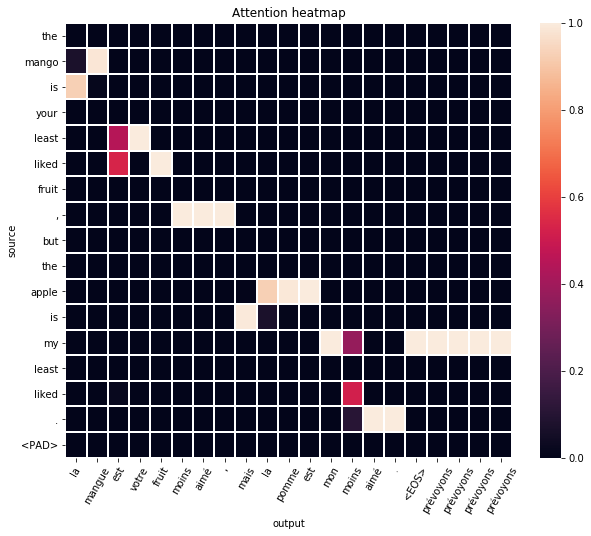

In [17]:
att , predicting_logits_ = sess.run([predicting_attention_matrices , predicting_logits], 
                                     feed_dict = {input_data : train_source_batch_pad ,
                                                  targets : train_target_batch_pad ,
                                                  source_sequence_length : train_source_batch_length ,
                                                  target_sequence_length : train_target_batch_length})    


# 隨機取一個樣本 i 畫出注意力矩陣
i = 4
matrix = att[: , i , ].T
src = train_source_batch_pad[i , :]
tgt = predicting_logits_[i , :]    

src_letter , tgt_letter = [] , []
for item in src:
    src_letter.append(source_int_to_letter[item])
for item in tgt :
    tgt_letter.append(target_int_to_letter[item])
print(' '.join(src_letter))
print(' '.join(tgt_letter))

df = pd.DataFrame(matrix , index = src_letter , columns = tgt_letter)
plt.figure(figsize=(10 , 8))
ax = sns.heatmap(df , linewidths = 1)
ax.set_xlabel('output')
ax.set_ylabel('source')
plt.xticks(rotation = 60)
plt.yticks(rotation = 0)
ax.set_title('Attention heatmap')
plt.show()

## Testing

In [18]:
import os    
sess = tf.Session()
new_saver = tf.train.import_meta_graph(os.path.join('trained_model/save_net.meta'))
new_saver.restore(sess, tf.train.latest_checkpoint(os.path.join('trained_model')))

graph = tf.get_default_graph()
input_data = graph.get_tensor_by_name('inputs:0')
targets = graph.get_tensor_by_name('targets:0')
source_sequence_length = graph.get_tensor_by_name('source_sequence_length:0')
target_sequence_length = graph.get_tensor_by_name('target_sequence_length:0')
logits = graph.get_tensor_by_name('predictions:0')

input_sentence = 'i dislike grapefruit , lemons , and peaches .'
test_source = []
for letter in input_sentence.split(' '):
    if letter in source_letter_to_int.keys():
        test_source.append(source_letter_to_int[letter])
    elif letter not in source_letter_to_int.values():
        test_source.append(source_letter_to_int['<UNK>'])
test_source = [test_source] * batch_size
test_source_length = [len(i) for i in test_source]
           
test_target = [0 for _ in range(0 , 100)] # test_target輸入的值可以隨便選，只要長度大於test_source即可
test_target = [test_target] * batch_size
test_target_length = [len(i) for i in test_target]

test_source = np.array(test_source)
test_target = np.array(test_target)
test_source_length = np.array(test_source_length)
test_target_length = np.array(test_target_length)

answer = sess.run(logits, feed_dict = {input_data : test_source ,
                                       targets : test_target ,
                                       source_sequence_length : test_source_length ,
                                       target_sequence_length : test_target_length})

answer = answer[0 , :]
answer_to_letter = []
for num in answer:
    if target_int_to_letter[num] == '<EOS>': break
    answer_to_letter.append(target_int_to_letter[num])

print('輸入的英文句子 : {}'.format(input_sentence))  
print('google翻譯的法文句子 : {}'.format("je n'aime pamplemousses , les citrons et les pêches ."))  
print('model翻譯的法文句子 : {}'.format(' '.join(answer_to_letter)))      

INFO:tensorflow:Restoring parameters from trained_model\save_net
輸入的英文句子 : i dislike grapefruit , lemons , and peaches .
google翻譯的法文句子 : je n'aime pamplemousses , les citrons et les pêches .
model翻譯的法文句子 : je n'aime pamplemousses , les citrons et les pêches .
